### 사전 훈련된 컨브넷 사용하기 (5.3 케라스 창시자에게 배우는 딥러닝 중)

- VGG16 구조는 2014년에 개발
- VGG, ResNet, Inception, Inception-ResNet, Xception 등
- 사전 훈련된 네트워크를 사용하는 방법 두 가지 : 특성 추출(feature extraction), 미세 조정(fine tuning)

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',          # 모델을 초기화할 가중치 체크 포인트(checkpoint) 지정
                  include_top = False,          # 완전 분류기를 포함할 것인가 : ImageNet은 클래스 1000개의 완전 분류기를 포함 -> 완전연결층을 직접 만들 예정
                  input_shape = (150, 150, 3))  # 이 값을 지정하지 않으면 어떤 크기의 입력도 처리 가능함

# include_top이 기본값 Ture이면, 합성곱 층 위에 안전 연결층이 추가되기 때문에,
# input_shape가 원본 모델과 동일한 (224, 224, 3)이 되어야 한다.

conv_base.trainable = False

# include_top :  전체 VGG16의 마지막 층 -> 분류를 담당하는 곳을 불러올지 말지를 결정하는 옵션
# 여기서는 직접 만든 로컬 네트워크를 연결할 것이므로
# 또한 불러올 부분은 새롭게 학습되는 것이 아니므로 -> 학습되지 않도록 .trainable 옵션을 False로 설정

In [2]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [4]:
# 최종 특성 맵의 크기는 (4, 4, 512) -> 이 특성 위에 완전 연결 층을 추가

from keras import models
from keras import layers

model = models.Sequential()       # 모델 이어 붙이기 - model(finetune model)
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [72]:
import keras
import tensorflow

print(keras.__version__)
print(tensorflow.__version__)

3.2.0
2.16.1


In [7]:
model.build(input_shape=(None, 150, 150, 3))    # input의 형태를 입력해줘야 정확한 Param 갯수가 출력된다.
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,239,170 (58.13 MB)

 Trainable params: 524,482 (2.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [76]:
# len(model.trainable_weights)  # conv_base를 동결하기 전 훈련되는 가중치이 수

In [20]:
# conv_base의 가중치를 동결

# conv_base.trainable = False
# len(model.trainable_weights)

0

In [ ]:
# Non-trainable params: 14,714,688 (56.13 MB)
# VGG Net의 파라미터는 학습이 진행되지 않음 -> 기 학습된 값을 그대로 사용
# 최종 분류를 위해 추가된 Layer에 대해서만 새롭게 학습
# : 평탄화 + 분류(2개) 방식의 문제로 축소


# 다양한 모델을 호출하는 방법
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.inception_v3 import inceptionV3
# from tensorflow.keras.applications.resnet import ResNet50
# from tensorflow.keras.applications.vgg19 import VGG19

# model_VGG16 = VGG16(weghts = 'imagenet')
# model_VGG19 = VGG19(weghts = 'imagenet')
# model_RESNET50 = ResNet50(weghts = 'imagenet')
# model_INCEPTIONV3 = InceptionV3(weghts = 'imagenet')

### 전이학습(Transfer Learning)
- 기존의 학습 결과를 가져와서 유사한 프로젝트에 사용하는 방법
- 진행 순서
1) 대규모 데이터셋에서 학습된 기존의 네트워크 불러오기 : VGGNet - VGG16
2) CNN 모델의 앞쪽을 이 네트워크로 채우기
3) 뒤쪽 레이어에서 내 프로젝트와 연결하기
4) 이 두 네트워크가 잘 맞물리게 미세 조정 (fine tunning)

In [ ]:
# 예를들어 "뇌 MRI" 사진을 판독하는 문제의 경우,
# 뇌 사진과 관련이 없는 수백만 장의 이미지넷 학습정보가 큰 역할을 하는 이유는,
# '형태'를 구분하는 기본적인 학습이 되어 있기 때문

# 딥러닝은 학습이 시작되면 어떤 픽셀의 조합이 '선'이고 어떤 형태의 그룹이 '면'이 되는지부터 파악해야 한다.
# 아무런 정보도 없이 MRI 사진 판별을 시작한다면, 이러한 기본적인 정보를 얻어내는 데도 
# 많은 시간을 쏟아야 한다. 전이학습은 이런 부분을 해결해준다.

# 출처 : https://m.blog.naver.com/mario002

#### 특성맵 출력
- 합성곱 층을 입력 이미지와 필터를 연산해서 얻은 결과
- 합성곱 층의 입력과 출력을 확인하면, 특성 맵에 대한 시각화가 가능함

In [10]:
import tensorflow as tf

# 특성뱁의 정의
# 전이학습 모델을 가져와서 입력과 출력을 임의로 정의함

ins = conv_base.inputs
outs = conv_base.layers[18].output

# [1] 첫번째 레이어를 통과하는 경우, 이미지의 특성 변화 확인
# 레이어 숫자를 증가시켜, 입력부터 그 층의 종단까지 처리 결과를 출력하여 확인

# 어떤 층의 특성맵을 출력할 지는 위의 outs에서 결정
feature_map = tf.keras.models.Model(ins, outs)  # 특성맵 추출을 위한 임시 모델의 정의

feature_map.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# 이미지 전처리

import cv2
import matplotlib.pyplot as plt
import numpy as np

img = plt.imread('car.jpg', cv2.IMREAD_ANYCOLOR)    # 이미지 저장 시, png로 저장시 4채널로 저장되므로 jpg로 저장할 것
img = cv2.resize(img, (150, 150))                   # 로딩한 이미지를 입력 크기에 맞게 리사이즈
input_img = np.expand_dims(img, axis=0)             # 이미지 차원의 조정

print(input_img.shape)                              # 입력 이미지 형태를 출력 확인
print(conv_base.layers[1].name)                     # 레이어 넘버를 입력해보고, 어느 층까지를 말하는 것인지 Layer 이름 출력 결과를 통해 확인할 것(240902)

feature = feature_map.predict(input_img)            # 이미지를 모델에 적용

(1, 150, 150, 3)
block1_conv1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


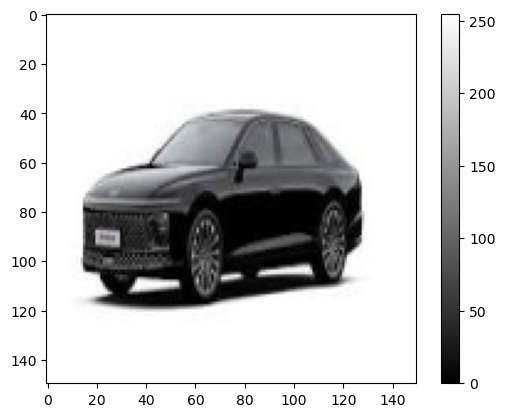

In [14]:
plt.figure()
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

(1, 4, 4, 512)


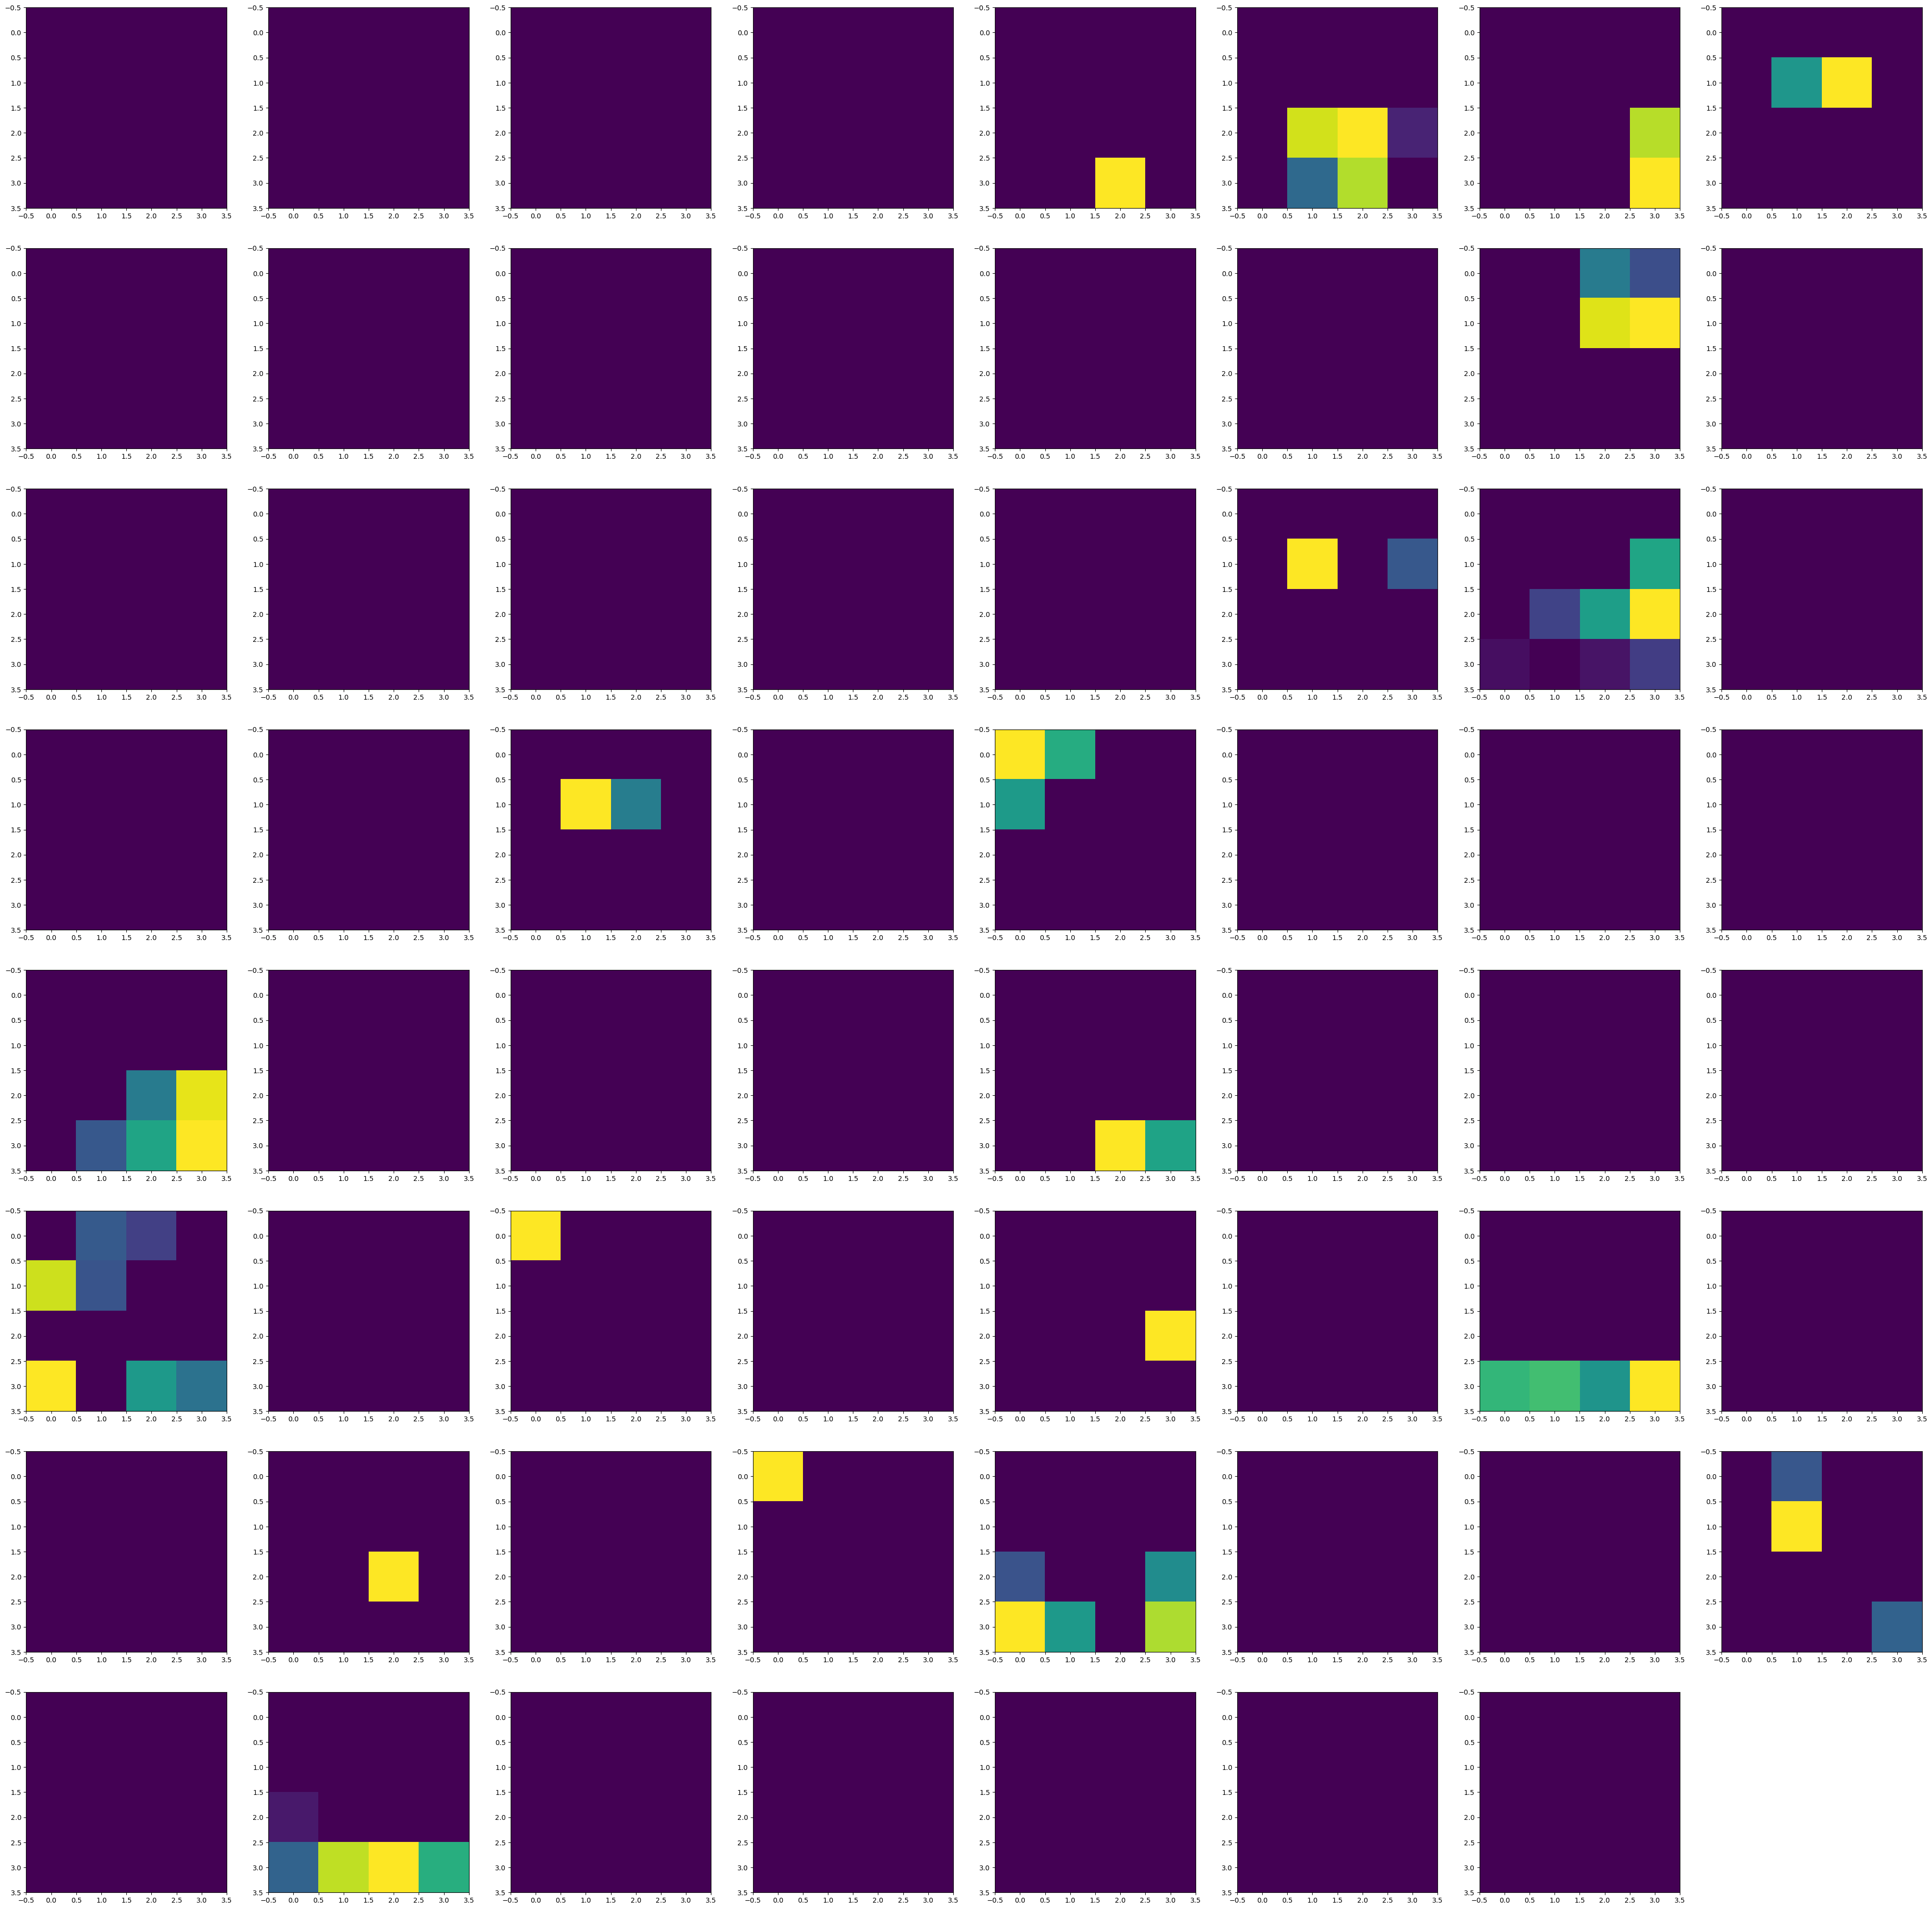

In [15]:
print(feature.shape)

fig = plt.figure(figsize=(50,50))

for i in range(63):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(feature[0, :, :, i])

In [ ]:
# outs = transfer_model.layers[18].output    # block_5까지 내려가면,
# 자동차의 형상은 거의 알아보기 힘든 수준까지 변화된다. (240902)

# 특징맵 -> 각 층에서 이미지의 어떤 특성에 주목하는가?

#### 보틀넥 피처(Bottleneck feature)
- 모델에서 가장 추상화된 피쳐
- 특히 CNN 모델에서 어파인 레이어 (Fully-Connected layer) 바로 전 CNN 블록의 output 값
- 가장 마지막 CNN 블록, 즉 Fully-Connected layer(affine layer) 또는 Dense layer라고도 부름
- 직전의 CNN 블록의 결과를 보틀넥 피쳐라고 부른다.
- CNN 모델은 각 CNN 블록의 풀링(pooling layer)레이어를 지나면서 피쳐 사이즈가 줄어들기(= 추상화) 때문에
- 피쳐 크기를 기준으로 생각하면 병을 뒤집어둔 모양과 비슷하다.

#### 파인 튜닝(Fine-tunning)
- 모델의 파라미터를 미세하게 조정하는 행위
- 딥러닝에서 이미 존재하는 모델에 추가 데이터를 투입하여 파라미터를 업데이트 하는 것
- VGG16 모델의 경우 1000개의 카테고리를 학습시켰기 때문에 고양이와 개 등 2개의 카테고리만 필요한
- 문제를 해결하는데 모든 레이어를 그대로 쓸 수는 없다.

- 따라서 가장 쉽게 이용하려면, 내 데이터를 해당모델로 예측(predict)하여 보틀넥 피쳐만 뽑아내고,
- 이를 이용하여 어파인 레이어(Fully-Connected)만 학습시켜서 사용하는 방법을 취하게 된다.

- 하지만 이 경우는 파인튜닝이라고 부르지 않는다. 피쳐를 추출해내는 레이어의 파라미터를 업데이트하지 않기 때문이다.
- 어파인 레이어를 업데이트를 하지 않냐고 생각할 수 있지만, 내가 새로 구성한 레이어이기 때문에 업데이트가 아니며,
- 초기 웨이트가 랜덤이기 때문에 정교하지도 않다.
- 파인튜닝을 했다고 말하려면, 기존에 학습이 된 레이어에 내 데이터를 추가로 학습시켜 파라미터를 업데이트 해야 한다.